In [572]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [573]:
# !pip install --upgrade k3d

In [3]:
# !pip install msgpack

In [755]:
from collections import defaultdict
from copy import deepcopy
import json
import os
import warnings
from io import BytesIO

import igl
import randomcolor
import trimesh
import k3d
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from joblib import Parallel, delayed

In [5]:
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
import sharpf.utils.abc_utils.hdf5.io_struct as io_struct
import sharpf.data.datasets.sharpf_io as sharpf_io
from sharpf.utils.plotting import display_depth_sharpness
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased
from sharpf.utils.abc_utils.mesh.io import trimesh_load


In [6]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r, 
                      plot=None, display=True):
    
    if None is plot:
        plot = k3d.plot(height=plot_height, camera_auto_fit=False)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances and not np.all(samples_distances == 1.0):
            max_dist = 0.5

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            v = -np.array([0., 1., 0.])
            max_dist = np.max(np.dot(samples, v))
            min_dist = np.min(np.dot(samples, v))
            colors = k3d.helpers.map_colors(
                np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)

        plot += k3d_points
        k3d_points.shader='3d'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    if display:
        plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))
    
    return plot

In [7]:
# mm/pixel
HIGH_RES = 0.02
MED_RES = 0.05
LOW_RES = 0.125
XLOW_RES = 0.25

DISPLAY_RES = 0.02 * 1.5

In [330]:
def display_sharpness2(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768,
                      cmap=k3d.colormaps.matplotlib_color_maps.coolwarm_r):
    
    plot = k3d.plot(height=plot_height)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color, shader='3d')
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            max_dist = 2.5

            colors = k3d.helpers.map_colors(
                samples_distances, cmap, [0, max_dist]
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            if samples_color == 'z':
                v = -np.array([0., 1., 0.])
                max_dist = np.max(np.dot(samples, v))
                min_dist = np.min(np.dot(samples, v))
                colors = k3d.helpers.map_colors(
                    np.dot(samples, v), k3d.colormaps.matplotlib_color_maps.viridis, [min_dist, max_dist]
                ).astype(np.uint32)
                k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
                
            else:
                k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
                
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            vectors = k3d.vectors(
                samples,
                directions * samples_distances[..., np.newaxis],
                use_head=False, 
                line_width=directions_width)
            print(vectors)
            plot += vectors

#             directions_to_plot = np.hstack((samples, samples + directions))
            
#             for i, dir_to_plot in enumerate(directions_to_plot):
#                 dir_to_plot = dir_to_plot.reshape((2, 3))
#                 if np.all(dir_to_plot[0] == dir_to_plot[1]):
#                     continue
#                 color = int(colors[i]) if None is not colors else samples_color
#                 plt_line = k3d.line(dir_to_plot, 
#                                     shader='mesh', width=directions_width, color=color)
#                 plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.display()
    
    if as_image:
        plot.fetch_screenshot()
        return Image(data=b64decode(plot.screenshot))

In [622]:
from sharpf.utils.convertor_utils.convertors_io import ViewIO, RangeVisionIO

def get_mesh(hdf5_filename, obj_mesh):
    dataset = Hdf5File(
        hdf5_filename,
        io=ViewIO,
        preload=PreloadTypes.LAZY,
        labels='*')

    with open(obj_filename, 'rb') as obj_file:
        obj_mesh, _, _ = trimesh_load(BytesIO(obj_file.read()))


    obj_alignment_transform = dataset[0]['obj_alignment']
    obj_scale = dataset[0]['obj_scale']
    mesh = obj_mesh.copy() \
        .apply_scale(obj_scale) \
        .apply_transform(obj_alignment_transform)
    
    return mesh

In [12]:
def fuse_points(n_points, list_predictions, list_indexes_in_whole, list_points):
    fused_points = np.zeros((n_points, 3))
    fused_distances = np.ones(n_points) * np.inf
    # fused_directions = np.ones((n_points, 3)) * np.inf

    iterable = zip(list_predictions, list_indexes_in_whole, list_points)
    for distances, indexes, points in tqdm(iterable):
        fused_points[indexes] = points
        assign_mask = fused_distances[indexes] > distances
        fused_distances[indexes[assign_mask]] = np.minimum(distances[assign_mask], 2.5)
        # fused_directions[indexes[assign_mask]] = directions[assign_mask]

    return fused_points, fused_distances, {}

In [973]:
import argparse
from glob import glob
from io import BytesIO
import os
import sys

import igl
import numpy as np
import trimesh.transformations as tt
from tqdm import tqdm
import yaml


from sharpf.data.annotation import ANNOTATOR_BY_TYPE
from sharpf.utils.camera_utils.view import CameraView
from sharpf.data.imaging import RaycastingImaging
from sharpf.utils.py_utils.config import load_func_from_config
from sharpf.utils.camera_utils.camera_pose import CameraPose, camera_to_display
from sharpf.utils.abc_utils.hdf5.dataset import Hdf5File, PreloadTypes
from sharpf.utils.abc_utils.mesh.io import trimesh_load
from sharpf.utils.convertor_utils.convertors_io import (
    ViewIO,
    write_annotated_views_to_hdf5)
from sharpf.utils.abc_utils.abc.feature_utils import (
    compute_features_nbhood,
    remove_boundary_features,
    submesh_from_hit_surfaces)
from sharpf.utils.convertor_utils.meshlab_project_parsers import load_meshlab_project
import sharpf.utils.convertor_utils.rangevision_utils as rv_utils
from sharpf.utils.camera_utils import matrix


In [150]:
def illustrate_camera(
    camera_pose: CameraPose,
    l=1.0,
    w=1.0,
    use_head=False,
    hs=1.0,
):
    camera_center = np.array([
        camera_pose.frame_origin,
        camera_pose.frame_origin,
        camera_pose.frame_origin])

    camera_frame = np.array([
        camera_pose.frame_axes
    ]) * l
    
    x_color = 0xff0000
    y_color = 0x00ff00
    z_color = 0x0000ff

    vectors = k3d.vectors(
        camera_center,
        camera_frame,
        use_head=use_head, 
        head_size=hs,
        line_width=w,
        colors=[x_color, x_color, y_color, y_color, z_color, z_color],)

    return vectors

In [602]:
def get_random_color(hue=None):
    rand_color = randomcolor.RandomColor()
    color = rand_color.generate(hue=hue)[0]
    color = int('0x' + color[1:], 16)
    return color

In [1033]:
def plot_alignment_quality(views, mesh):

    distances = np.concatenate(
        [np.sqrt(igl.point_mesh_squared_distance(
            view.depth, mesh.vertices, mesh.faces)[0])
        for view in views])

    plt.figure(figsize=(12, 6))
    _ = plt.hist(distances, bins=100, range=[0, 10])
    plt.gca().set_yscale('log')
    plt.gca().set_ylim([0, 1e5])
    plt.gca().set_xlim([0, 10])
    plt.gca().set_xlabel('Distance to ground truth CAD model, mm', fontsize=14)
    plt.gca().set_ylabel('Number of point samples', fontsize=14)
    plt.gca().tick_params(axis='both', which='major', labelsize=14)
    plt.gca().tick_params(axis='both', which='minor', labelsize=14)
    
    for q in [0.5, 0.95, 0.99]:
        q_val = np.quantile(distances, q)
        label = '{0:3.0f}%: {1:0.2f}'.format(q * 100, q_val)
        plt.axvline(q_val, 0, 1e5, 
                    color=plt.get_cmap('rainbow')(q), linewidth=3, 
                    label=label)
        print(label)
    plt.legend(fontsize=16, loc='upper right')

In [957]:
def transform_to_frame(matrix, frame):
    """Given a transform defined by its matrix in a particular coordinate frame,
    compute its matrix under a given coordinate frame transformation.
    
    Parameters
    -------------
    matrix : (4, 4) float
      Homogeneous transform matrix
      
    frame : (4, 4) float
      Homogeneous coordinate frame transformation matrix

    Returns
    --------------
    transformed_matrix : (4, 4) float
      Homogeneous transform matrix for a given frame 
    """
    matrix = np.asanyarray(matrix, dtype=np.float64)
    frame = np.asanyarray(frame, dtype=np.float64)

    return frame @ matrix @ np.linalg.inv(frame)
    

In [958]:
def plot_views(
    views_iterable,
    obj_mesh,
):
    views = [
        CameraView(
            depth=tt.transform_points(
                scan['points'].reshape((-1, 3)), 
                scan['points_alignment']),
            signal=None,
            faces=scan['faces'].reshape((-1, 3)),
            extrinsics=np.dot(scan['points_alignment'], scan['extrinsics']),
            intrinsics=scan['intrinsics'],
            state='points')
        for scan in tqdm(views_iterable, desc='Loading scans')]


    plot = k3d.plot(grid_visible=True, height=768)

    for view in views:
        scan_mesh = trimesh.base.Trimesh(
            view.depth, 
            view.faces, 
            process=False, 
            validate=False)

        plot += k3d.points(
            scan_mesh.vertices,
            point_size=0.25,
            color=get_random_color(hue='green'),
            shader='flat')

    obj_scale = views_iterable[0]['obj_scale']
    obj_alignment = views_iterable[0]['obj_alignment']
    mesh = obj_mesh.copy().apply_scale(obj_scale).apply_transform(obj_alignment)
    plot += k3d.mesh(
        mesh.vertices, 
        mesh.faces, 
        color=0xaaaaaa,
        flat_shading=False)

    plot.display()
    
    return views, mesh

In [1054]:
input_dir = '/data/SharpF_200_01_21/9top_folder/'
!ls $input_dir

00510325_0769ac8e70aa984887cf08ec_000__28.9mm.stl
00510325_0769ac8e70aa984887cf08ec_features_000.yml
00510325_0769ac8e70aa984887cf08ec_trimesh_000.obj
9top.hdf5
9top.x
9top_0.ply
9top_1.ply
9top_10.ply
9top_11.ply
9top_2.ply
9top_3.ply
9top_4.ply
9top_5.ply
9top_6.ply
9top_7.ply
9top_8.ply
9top_9.ply
9top_folder_preprocessed.hdf5
alignment.mlp


In [1055]:
stl_filename = glob(os.path.join(input_dir, '*.stl'))[0]
obj_filename = glob(os.path.join(input_dir, '*.obj'))[0]
yml_filename = glob(os.path.join(input_dir, '*.yml'))[0]
meshlab_filename = glob(os.path.join(input_dir, '*.mlp'))[0]
hdf5_raw_filename = sorted(glob(os.path.join(input_dir, '*.hdf5')))[0]
hdf5_preprocessed_filename = glob(os.path.join(input_dir, '*_preprocessed.hdf5'))[0]
item_id = os.path.basename(stl_filename).split('__')[0]

In [1056]:
with open(obj_filename, 'rb') as obj_file:
    print('obj...', end='')
    obj_mesh, _, _ = trimesh_load(BytesIO(obj_file.read()))
    
with open(yml_filename, 'rb') as yml_file:
    print('yml...', end='')
    yml_features = yaml.load(BytesIO(yml_file.read()), Loader=yaml.Loader)

print('meshlab...', end='')
_, manual_alignment_transforms, _, stl_transform = load_meshlab_project(meshlab_filename)


obj...yml...meshlab...

In [1057]:
print('hdf5...')
dataset_preprocessed = Hdf5File(
    hdf5_preprocessed_filename,
    io=ViewIO,
    preload=PreloadTypes.LAZY,
    labels='*')


hdf5...


In [1058]:
obj_alignment_transform = dataset_preprocessed[0]['obj_alignment']
obj_scale = dataset_preprocessed[0]['obj_scale']
mesh = obj_mesh.copy() \
    .apply_scale(obj_scale) \
    .apply_transform(obj_alignment_transform)

In [1059]:
rvn = rv_utils.RangeVisionNames

flip_z = np.array([
    [1, 0, 0, 0], 
    [0, 1, 0, 0], 
    [0, 0, -1, 0], 
    [0, 0, 0, 1]])

dataset_raw = Hdf5File(
    hdf5_raw_filename,
    io=RangeVisionIO,
    preload=PreloadTypes.LAZY,
    labels='*')

output_scans = []
for scan_index, scan in enumerate(dataset_raw):

    # The algorithm:
    # * check if scan is usable?
    #  1) load the raw scanned 3D points from HDF5 (directly exported from scanner)
    points = np.array(scan[rvn.points]).reshape((-1, 3))
    faces = np.array(scan[rvn.faces]).reshape((-1, 3))

    #  1a) we know that the scan must be mirrored, do this
    scan_mesh = trimesh.base.Trimesh(points, faces, process=False, validate=False)
    scan_mesh.vertices = tt.transform_points(scan_mesh.vertices, flip_z)
    scan_mesh.invert()
    points, faces = scan_mesh.vertices, scan_mesh.faces

    #  2a) load the automatic scanner alignment transformation
    rv_alignment_transform = np.array(scan[rvn.alignment]).reshape((4, 4))
#     rv_alignment_transform = transform_to_frame(rv_alignment_transform, flip_z)
    
    #  2b) load the transformation that we thought was the extrinsic of scanner (they are not)
    rxyz_euler_angles = np.array(scan[rvn.rxyz_euler_angles])
    translation = np.array(scan[rvn.translation])
    wrong_extrinsics = rv_utils.get_camera_extrinsic(
        rxyz_euler_angles, translation).camera_to_world_4x4

    #  2c) load manual alignments from meshlab project
    manual_alignment_transform = manual_alignment_transforms[scan_index]

    #  2e) compute transform that would align scans in source frame
    manual_alignment_transform = transform_to_frame(
        manual_alignment_transform, np.linalg.inv(wrong_extrinsics))
    alignment_transform = manual_alignment_transform @ rv_alignment_transform
    alignment_transform = transform_to_frame(alignment_transform, flip_z)
#     points_wrt_calib_board = tt.transform_points(points, alignment_transform)

    #  2d) load vertex_matrix, this is transform to board coordinate system
    scan_to_board_transform = np.linalg.inv(
        np.array(scan[rvn.vertex_matrix]).reshape((4, 4)))

    #  2d) compute transform that would align scans in board frame
    board_alignment_transform = transform_to_frame(alignment_transform, scan_to_board_transform)
    points_wrt_calib_board = tt.transform_points(points, scan_to_board_transform)

    #  3) compute transform that would align mesh to points in board frame
    obj_alignment_transform = flip_z @ np.linalg.inv(wrong_extrinsics) @ stl_transform
    obj_alignment_transform = scan_to_board_transform @ obj_alignment_transform

    #  4) get extrinsics of right camera
    right_extrinsics_4x4 = rv_utils.get_right_camera_extrinsics(
        rxyz_euler_angles, translation).camera_to_world_4x4

    #  5) get projection matrix
    focal_length = scan[rvn.focal_length]
    intrinsics_f = matrix.get_camera_intrinsic_f(focal_length)

    #  6) get intrinsics matrix
    pixel_size_xy = scan[rvn.pixel_size_xy]
    center_xy = scan[rvn.center_xy]
    intrinsics_s = matrix.get_camera_intrinsic_s(
        pixel_size_xy[0],
        pixel_size_xy[1],
        rv_utils.RV_SPECTRUM_CAM_RESOLUTION[0],
        rv_utils.RV_SPECTRUM_CAM_RESOLUTION[1])
    intrinsics = np.stack((intrinsics_f, intrinsics_s))

    output_scan = {
        'points': np.ravel(points_wrt_calib_board),
        'faces': np.ravel(faces),
        'points_alignment': board_alignment_transform,
        'extrinsics': right_extrinsics_4x4,
        'intrinsics': intrinsics,
        'obj_alignment': obj_alignment_transform,
        'obj_scale': obj_scale,
        'item_id': item_id,
    }
    output_scans.append(output_scan)


In [1218]:
views_output, mesh_output = plot_views(output_scans, obj_mesh)

Loading scans: 100%|██████████| 12/12 [00:00<00:00, 2221.46it/s]
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [1219]:
views_preprocessed, mesh_preprocessed = plot_views(dataset_preprocessed, obj_mesh)

Loading scans: 100%|██████████| 12/12 [00:00<00:00, 3798.33it/s]


Output()

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


 50%: 0.17
 95%: 2.37
 99%: 4.73


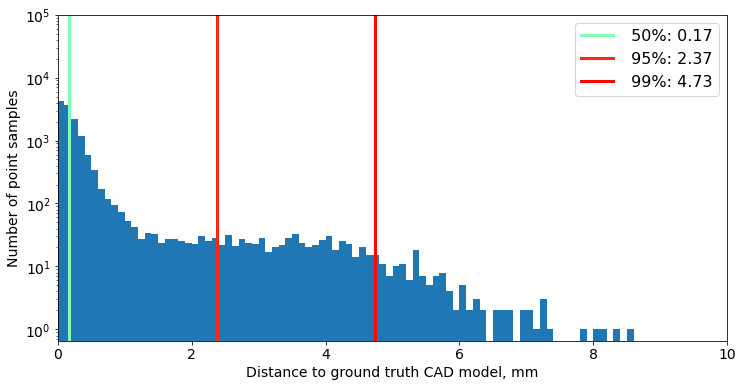

In [1062]:
plot_alignment_quality(views_preprocessed, mesh_preprocessed)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


 50%: 0.17
 95%: 2.37
 99%: 4.73


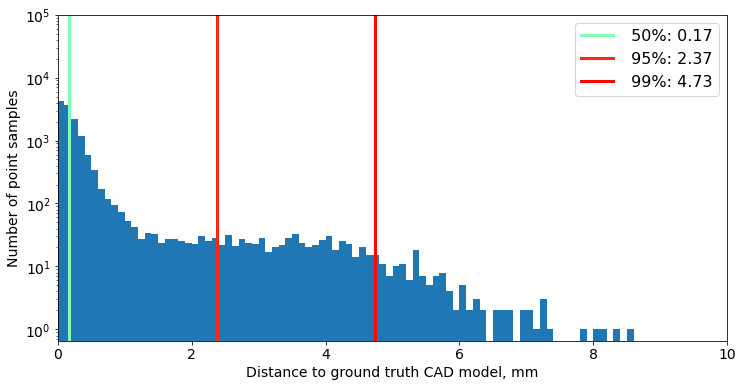

In [1063]:
plot_alignment_quality(views_output, mesh_output)

In [1220]:
view = views_output[10]

In [1221]:
plot = k3d.plot(grid_visible=True, height=768)

# for view in views:
plot += k3d.points(
    view.depth,
    point_size=0.25, 
    color=get_random_color(hue='green'),
    shader='flat')

plot += illustrate_camera(view.pose, l=2000, w=10)

obj_scale = output_scans[0]['obj_scale']
obj_alignment = output_scans[0]['obj_alignment']
mesh = obj_mesh.copy().apply_scale(obj_scale).apply_transform(obj_alignment)
plot += k3d.mesh(
    mesh.vertices, 
    mesh.faces, 
    color=0xaaaaaa, 
    flat_shading=False)

plot.display()

Output()

In [1222]:
pixels_view = view.to_pixels()

In [1223]:
imaging = RaycastingImaging(
    resolution_image=2048, 
    resolution_3d=0.5, 
    projection=None, 
    validate_image=False)

In [1224]:
image_parallel, points_parallel, normals_parallel = imaging.get_image_from_pose(mesh_output, view.pose)

In [1225]:
def crop_around_nonzero(image):
    yy, xx = np.where(image)
    crop = image[np.min(yy):np.max(yy), np.min(xx):np.max(xx)]
    return crop

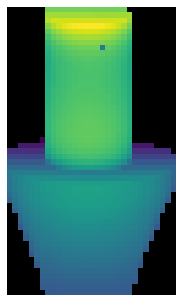

In [1226]:
depth_images_for_display = [
    camera_to_display(crop_around_nonzero(image_parallel))
    
]
# sharpness_images_for_display = [
#     pixels_view.signal[
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
# ]

display_depth_sharpness(
    depth_images=depth_images_for_display,
    sharpness_images=None,
    ncols=1,
    axes_size=(4, 4),
    max_sharpness=max_distance_to_feature)

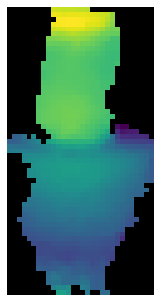

In [1227]:
depth_images_for_display = [
    crop_around_nonzero(pixels_view.depth)
]
# sharpness_images_for_display = [
#     pixels_view.signal[
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
# ]

display_depth_sharpness(
    depth_images=depth_images_for_display,
    sharpness_images=None,
    ncols=1,
    axes_size=(4, 4),
    max_sharpness=max_distance_to_feature)

In [1228]:
camera_to_display(crop_around_nonzero(image_parallel)).shape, crop_around_nonzero(pixels_view.depth).shape

((53, 31), (59, 30))

In [1124]:
from sharpf.utils.abc_utils.abc.feature_utils import get_curves_extents


In [1140]:

def scale_mesh(
        mesh,
        features,
        default_mesh_extent_mm,
        resolution_mm_per_point,
        short_curve_quantile=0.05,
        n_points_per_curve=4
):
    """Scale the mesh to achieve a desired sampling on feature curves.

    :param mesh: input mesh
    :param features: feature description for input mesh
    :param default_mesh_extent_mm: some default size of the mesh
    :param resolution_mm_per_point: inter-measurement distance (scanning resolution)
    :param short_curve_quantile: percentage of feature curves, below which we allow
                                 the curves to be undersampled
    :param n_points_per_curve: number of measurement samples that should be landing
                               on a typical feature curve along its linear spatial extent
    :return: scaled mesh
    """

    # First, make our mesh have some "default" spatial extent (in mm).
    scale_to_default = default_mesh_extent_mm / np.max(mesh.bounding_box.extents)
    mesh = mesh.apply_scale(scale_to_default)

    # Our goal is to sample each feature with a specified
    # number of point samples. For this, we first compute distribution of
    # feature curve extents (measured by bounding boxes) in "default" scale.
    curves_extents_mm = get_curves_extents(mesh, features)

    # We compute feature curve extents that we want sampled exactly
    # with the specified number of points.
    # Longer curves shall receive larger number of points,
    # while shorter curves will be under-sampled.
    default_curve_extent_mm = np.quantile(curves_extents_mm, short_curve_quantile)

    # We compute spatial extents that the specified number of points
    # must take when sampling the curve with the specified resolution.
    resolution_mm_per_curve = resolution_mm_per_point * n_points_per_curve

    scale_to_resolution = resolution_mm_per_curve / default_curve_extent_mm
    mesh = mesh.apply_scale(scale_to_resolution)

    return mesh, scale_to_default * scale_to_resolution


# parameters used to generate the fabricated mesh
DEFAULT_MESH_EXTENT_MM = 10.0  # mm
BASE_N_POINTS_PER_SHORT_CURVE = 8
BASE_RESOLUTION_3D = 0.15  # mm
SHORT_CURVE_QUANTILE = 0.25  # 25%
TARGET_RESOLUTION_3D = 1.0  # mm


In [1141]:
mesh, obj_scale = scale_mesh(
    obj_mesh.copy(),
    yml_features,
    DEFAULT_MESH_EXTENT_MM,
    TARGET_RESOLUTION_3D,
    short_curve_quantile=SHORT_CURVE_QUANTILE,
    n_points_per_curve=BASE_N_POINTS_PER_SHORT_CURVE)

In [1147]:
mesh.extents

array([21.78263567, 28.93929738, 15.99999994])

In [1144]:
np.quantile(get_curves_extents(mesh, yml_features), 0.25) / 0.5

15.999999962121406

In [1154]:
WholeDepthMapIO = io_struct.HDF5IO({
        'image': io_struct.Float64('image'),
        'normals': io_struct.Float64('normals'),
        'distances': io_struct.Float64('distances'),
        'directions': io_struct.Float64('directions'),
        'indexes_in_whole': io_struct.Float64('indexes_in_whole'),
        'item_id': io_struct.AsciiString('item_id'),
        'orig_vert_indices': io_struct.VarInt32('orig_vert_indices'),
        'orig_face_indexes': io_struct.VarInt32('orig_face_indexes'),
        'has_sharp': io_struct.Bool('has_sharp'),
        'num_sharp_curves': io_struct.Int8('num_sharp_curves'),
        'num_surfaces': io_struct.Int8('num_surfaces'),
        'camera_pose': io_struct.Float64('camera_pose'),
        'mesh_scale': io_struct.Float64('mesh_scale'),
        'has_smell_coarse_surfaces_by_num_faces': io_struct.Bool('has_smell_coarse_surfaces_by_num_faces'),
        'has_smell_coarse_surfaces_by_angles': io_struct.Bool('has_smell_coarse_surfaces_by_angles'),
        'has_smell_deviating_resolution': io_struct.Bool('has_smell_deviating_resolution'),
        'has_smell_sharpness_discontinuities': io_struct.Bool('has_smell_sharpness_discontinuities'),
        'has_smell_bad_face_sampling': io_struct.Bool('has_smell_bad_face_sampling'),
        'has_smell_mismatching_surface_annotation': io_struct.Bool('has_smell_mismatching_surface_annotation'),
        'has_smell_raycasting_background': io_struct.Bool('has_smell_raycasting_background'),
        'has_smell_depth_discontinuity': io_struct.Bool('has_smell_depth_discontinuity'),
        'has_smell_mesh_self_intersections': io_struct.Bool('has_smell_mesh_self_intersections'),
    },
    len_label='has_sharp',
    compression='lzf')

In [1156]:
synthetic_dataset = Hdf5File(
    '/logs/abc_0051_00510325_0769ac8e70aa984887cf08ec_000.hdf5',
    io=WholeDepthMapIO,
    labels='*')

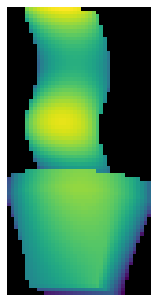

In [1196]:
s = 64
depth_images_for_display = [
    crop_around_nonzero(synthetic_dataset[7]['image'])
]
# [
#         slice(1024 // 2 - s, 1024 // 2 + s),
#         slice(1024 // 2 - s, 1024 // 2 + s)]
# sharpness_images_for_display = [
#     pixels_view.signal[
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
# ]

display_depth_sharpness(
    depth_images=depth_images_for_display,
    sharpness_images=None,
    ncols=1,
    axes_size=(4, 4),
    max_sharpness=max_distance_to_feature)

In [1199]:
camera_to_display(crop_around_nonzero(image_parallel)).shape, \
crop_around_nonzero(pixels_view.depth).shape, \
crop_around_nonzero(synthetic_dataset[7]['image']).shape

((61, 41), (69, 40), (78, 39))

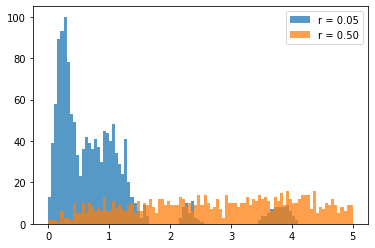

In [1216]:
x = item['image'].ravel()[np.flatnonzero(item['image'])]
plt.figure()
_= plt.hist(x-np.min(x), bins=100, range=[0, 5],
            histtype='stepfilled', alpha=0.75, label='r = 0.05')
    
x = image_parallel.ravel()[np.flatnonzero(image_parallel)]
_ = plt.hist(x-np.min(x), bins=100, range=[0, 5],
             histtype='stepfilled', alpha=0.75, label='r = 0.50')
plt.legend()

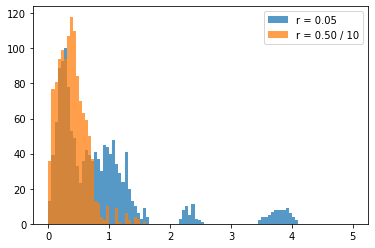

In [1217]:
x = item['image'].ravel()[np.flatnonzero(item['image'])]
plt.figure()
_= plt.hist(x-np.min(x), bins=100, range=[0, 5],
            histtype='stepfilled', alpha=0.75, label='r = 0.05')
    
x = image_parallel.ravel()[np.flatnonzero(image_parallel)] / 10
_ = plt.hist(x-np.min(x), bins=100, range=[0, 5],
             histtype='stepfilled', alpha=0.75, label='r = 0.50 / 10')
plt.legend()

In [600]:
# plot = k3d.plot(grid_visible=True, height=768)

# view = views[0]
# rand_color = randomcolor.RandomColor()

# for view in views:
#     color = rand_color.generate(hue='green')[0]
#     color = int('0x' + color[1:], 16)

#     plot += k3d.points(
#         view.depth,
#         point_size=0.25, 
#         color=color,
#         shader='flat')
    
#     plot += illustrate_camera(view.pose, l=100, w=10)

# # obj_scale = output_scans[0]['obj_scale']
# # obj_alignment = output_scans[0]['obj_alignment']
# # mesh = obj_mesh.copy().apply_scale(obj_scale).apply_transform(obj_alignment)
# # plot += k3d.mesh(
# #     mesh.vertices, mesh.faces, 
# #     color=0xaaaaaa,)

# plot.display()

In [971]:
max_distance_to_feature = 2.5

annotation_config = {
    "type": "surface_based_aabb",
    "distance_upper_bound": max_distance_to_feature,
    "always_check_adjacent_surfaces": True
}
annotator = load_func_from_config(ANNOTATOR_BY_TYPE, annotation_config)


{'resampling': <class 'sharpf.data.annotation.SharpnessResamplingAnnotator'>, 'global_aabb': <class 'sharpf.data.annotation.AABBGlobalAnnotator'>, 'surface_based_aabb': <class 'sharpf.data.annotation.AABBSurfacePatchAnnotator'>} {'type': 'surface_based_aabb', 'distance_upper_bound': 2.5, 'always_check_adjacent_surfaces': True}


In [564]:
view = views[5]
view_alignment = view_alignments[5]

In [565]:
view.depth

array([[-131.6307776 ,  -62.70259225,  -45.65675416],
       [-131.86250729,  -62.54636634,  -45.19232061],
       [-131.21300191,  -63.61882933,  -46.21007101],
       ...,
       [-109.38102153, -122.46957917,  -27.97109111],
       [-109.85094462, -122.14384142,  -27.8899059 ],
       [-110.28027334, -121.84604037,  -27.74598016]])

In [541]:
points = view.depth
# aligned_points = tt.transform_points(points, view_alignment)

distance_sq, mesh_face_indexes, _ = igl.point_mesh_squared_distance(
    points,
    mesh.vertices,
    mesh.faces)


nbhood, mesh_vertex_indexes, mesh_face_indexes = \
        submesh_from_hit_surfaces(mesh, yml_features, mesh_face_indexes)

# create annotations: condition the features onto the nbhood
nbhood_features = compute_features_nbhood(
    mesh,
    yml_features,
    mesh_face_indexes,
    mesh_vertex_indexes=mesh_vertex_indexes)

# remove vertices lying on the boundary (sharp edges found in 1 face only)
nbhood_features = remove_boundary_features(
    nbhood,
    nbhood_features,
    how='edges')

distances, directions, has_sharp = annotator.annotate(
    nbhood,
    nbhood_features,
    points)


In [542]:
view.signal = np.hstack((
    np.atleast_2d(distances).T,
    directions,
))

In [543]:
image_view = view.to_image()

In [544]:
pixel_view = view.to_pixels()
image = pixel_view.depth
distances, directions = pixel_view.signal[:, :, 0], pixel_view.signal[:, :, 1:]

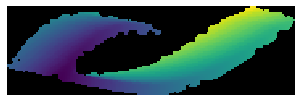

In [545]:
s = 128
# depth_images_for_display = [
#     image[
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
# ]
# sharpness_images_for_display = [
#     distances[
#         slice(1536 // 2 - s, 1536 // 2 + s),
#         slice(2048 // 2 - s, 2048 // 2 + s)]
# ]

yy, xx = np.where(image)
image_crop = image[np.min(yy):np.max(yy), np.min(xx):np.max(xx)]



depth_images_for_display = [
    image_crop
]
sharpness_images_for_display = [
    distances[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)]
]


display_depth_sharpness(
    depth_images=depth_images_for_display,
    sharpness_images=None,
    ncols=1,
    axes_size=(4, 4),
    max_sharpness=max_distance_to_feature)

In [571]:
image_crop.shape[1] * 0.5

89.5

In [546]:
from scipy.spatial import cKDTree

In [547]:
nn_distances, nn_indexes = cKDTree(view.depth, leafsize=1024).query(view.depth, k=2)

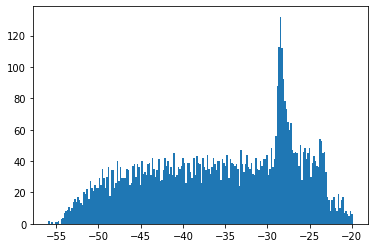

In [554]:
_ = plt.hist(view.depth[:, -1], bins=200)
# plt.gca().set_xlim([0, 1.])

In [566]:
tt.transform_points(view.depth, np.linalg.inv(view_alignment))

array([[  24.01161622, -144.77584916,   -0.58173841],
       [  24.54036261, -144.73450683,   -0.6936412 ],
       [  23.02334667, -145.21300266,   -0.97213439],
       ...,
       [   1.29309369, -165.10227499,  -59.32393624],
       [   1.74694436, -165.20038312,  -58.98054336],
       [   2.21205944, -165.2746501 ,  -58.71244629]])

array([[ -0.5316579 ,   0.72052132,  -0.44518201, -12.36754024],
       [  0.36959299,   0.67030638,   0.64349648,  27.2316142 ],
       [  0.76206288,   0.17758514,  -0.62267317, -48.43501242],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [88]:
display_sharpness2(
    nbhood, plot_meshvert=False, meshvert_psize=0.01,
    samples=aligned_points, 
    samples_distances=image_view.signal[:, 0],
    samples_color=0x0000ff, samples_psize=0.25,
    directions=None)



/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [300]:

AnnotatedViewIO = io_struct.HDF5IO({
    'points': io_struct.Float64('points'),
    'faces': io_struct.VarInt32('faces'),
    'points_alignment': io_struct.Float64('points_alignment'),
    'extrinsics': io_struct.Float64('extrinsics'),
    'intrinsics': io_struct.Float64('intrinsics'),
    'obj_alignment': io_struct.Float64('obj_alignment'),
    'obj_scale': io_struct.Float64('obj_scale'),
    'item_id': io_struct.AsciiString('item_id'),

    'distances': io_struct.Float64('distances'),
    'directions': io_struct.Float64('directions'),
    'orig_vert_indices': io_struct.VarInt32('orig_vert_indices'),
    'orig_face_indexes': io_struct.VarInt32('orig_face_indexes'),
    'has_sharp': io_struct.Bool('has_sharp'),
    'num_sharp_curves': io_struct.Int8('num_sharp_curves'),
    'num_surfaces': io_struct.Int8('num_surfaces'),
},
    len_label='item_id',
    compression='lzf')

In [301]:
dataset = Hdf5File(
    '/logs/10side_images.hdf5',
    io=AnnotatedViewIO,
    preload=PreloadTypes.LAZY,
    labels='*')

In [302]:
views = [
        CameraView(
            depth=scan['points'],
            signal=scan['distances'],
            faces=scan['faces'].reshape((-1, 3)),
            extrinsics=np.dot(scan['points_alignment'], scan['extrinsics']),
            intrinsics=scan['intrinsics'],
            state='pixels')
        for scan in dataset]
view_alignments = [scan['points_alignment'] for scan in dataset]

In [303]:
plot_height = 768
plot = k3d.plot(grid_visible=True, height=plot_height)

import randomcolor
rand_color = randomcolor.RandomColor()

for view, view_alignment in zip(views, view_alignments):
    color = rand_color.generate(hue='green')[0]
    color = int('0x' + color[1:], 16)

    plot += k3d.points(
        view.to_points().depth,
        point_size=0.25, 
        color=color,
        shader='flat')
    
    plot += illustrate_camera(view.pose, l=100, w=10)

# obj_scale = output_scans[0]['obj_scale']
# obj_alignment = output_scans[0]['obj_alignment']
# mesh = obj_mesh.copy().apply_scale(obj_scale).apply_transform(obj_alignment)
# plot += k3d.mesh(
#     mesh.vertices, mesh.faces, 
#     color=0xaaaaaa,)

plot.display()

Output()

In [304]:
v1 = views[0]
v2 = views[1]

In [305]:
v2r = v2.reproject_to(v1)

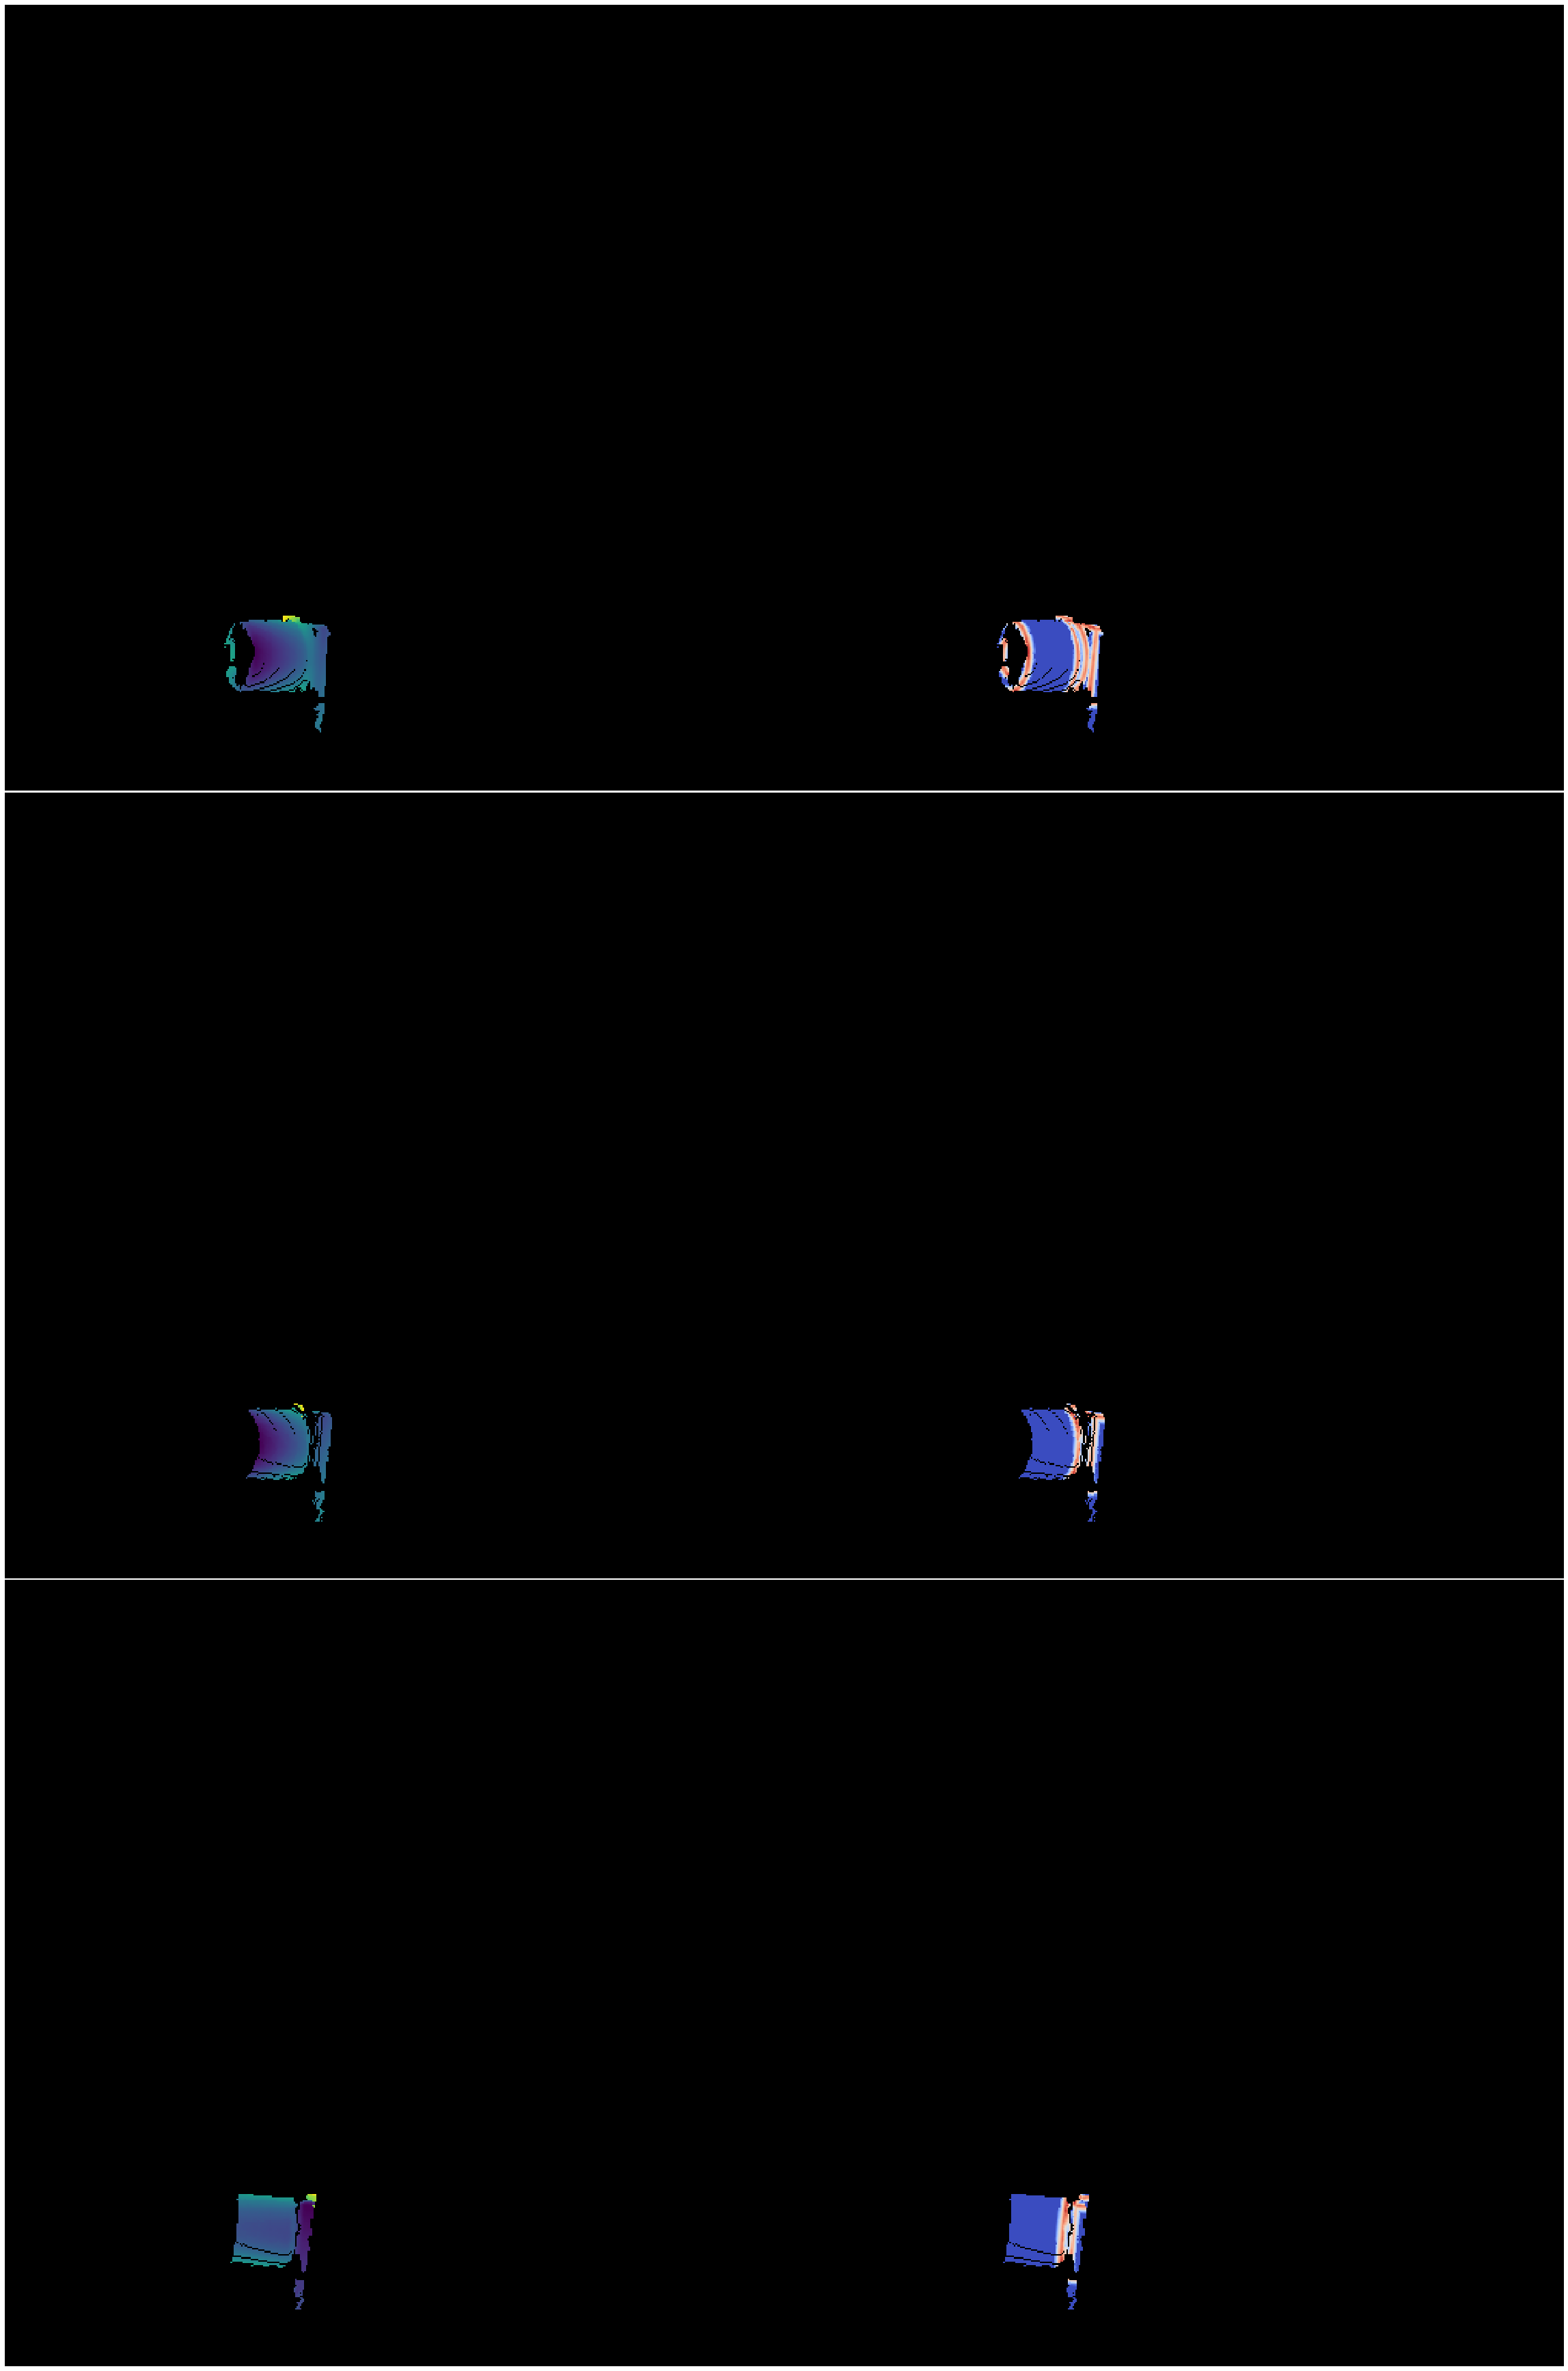

In [308]:
s = 256
depth_images_for_display = [
    v1.depth[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)],
    v2r.depth[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)],
    v2.depth[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)],
]
sharpness_images_for_display = [
    v1.signal[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)],
    v2r.signal[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)],
    v2.signal[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)],
]
display_depth_sharpness(
    depth_images=depth_images_for_display,
    sharpness_images=sharpness_images_for_display,
    ncols=1,
    axes_size=(16, 16),
    max_sharpness=max_distance_to_feature)

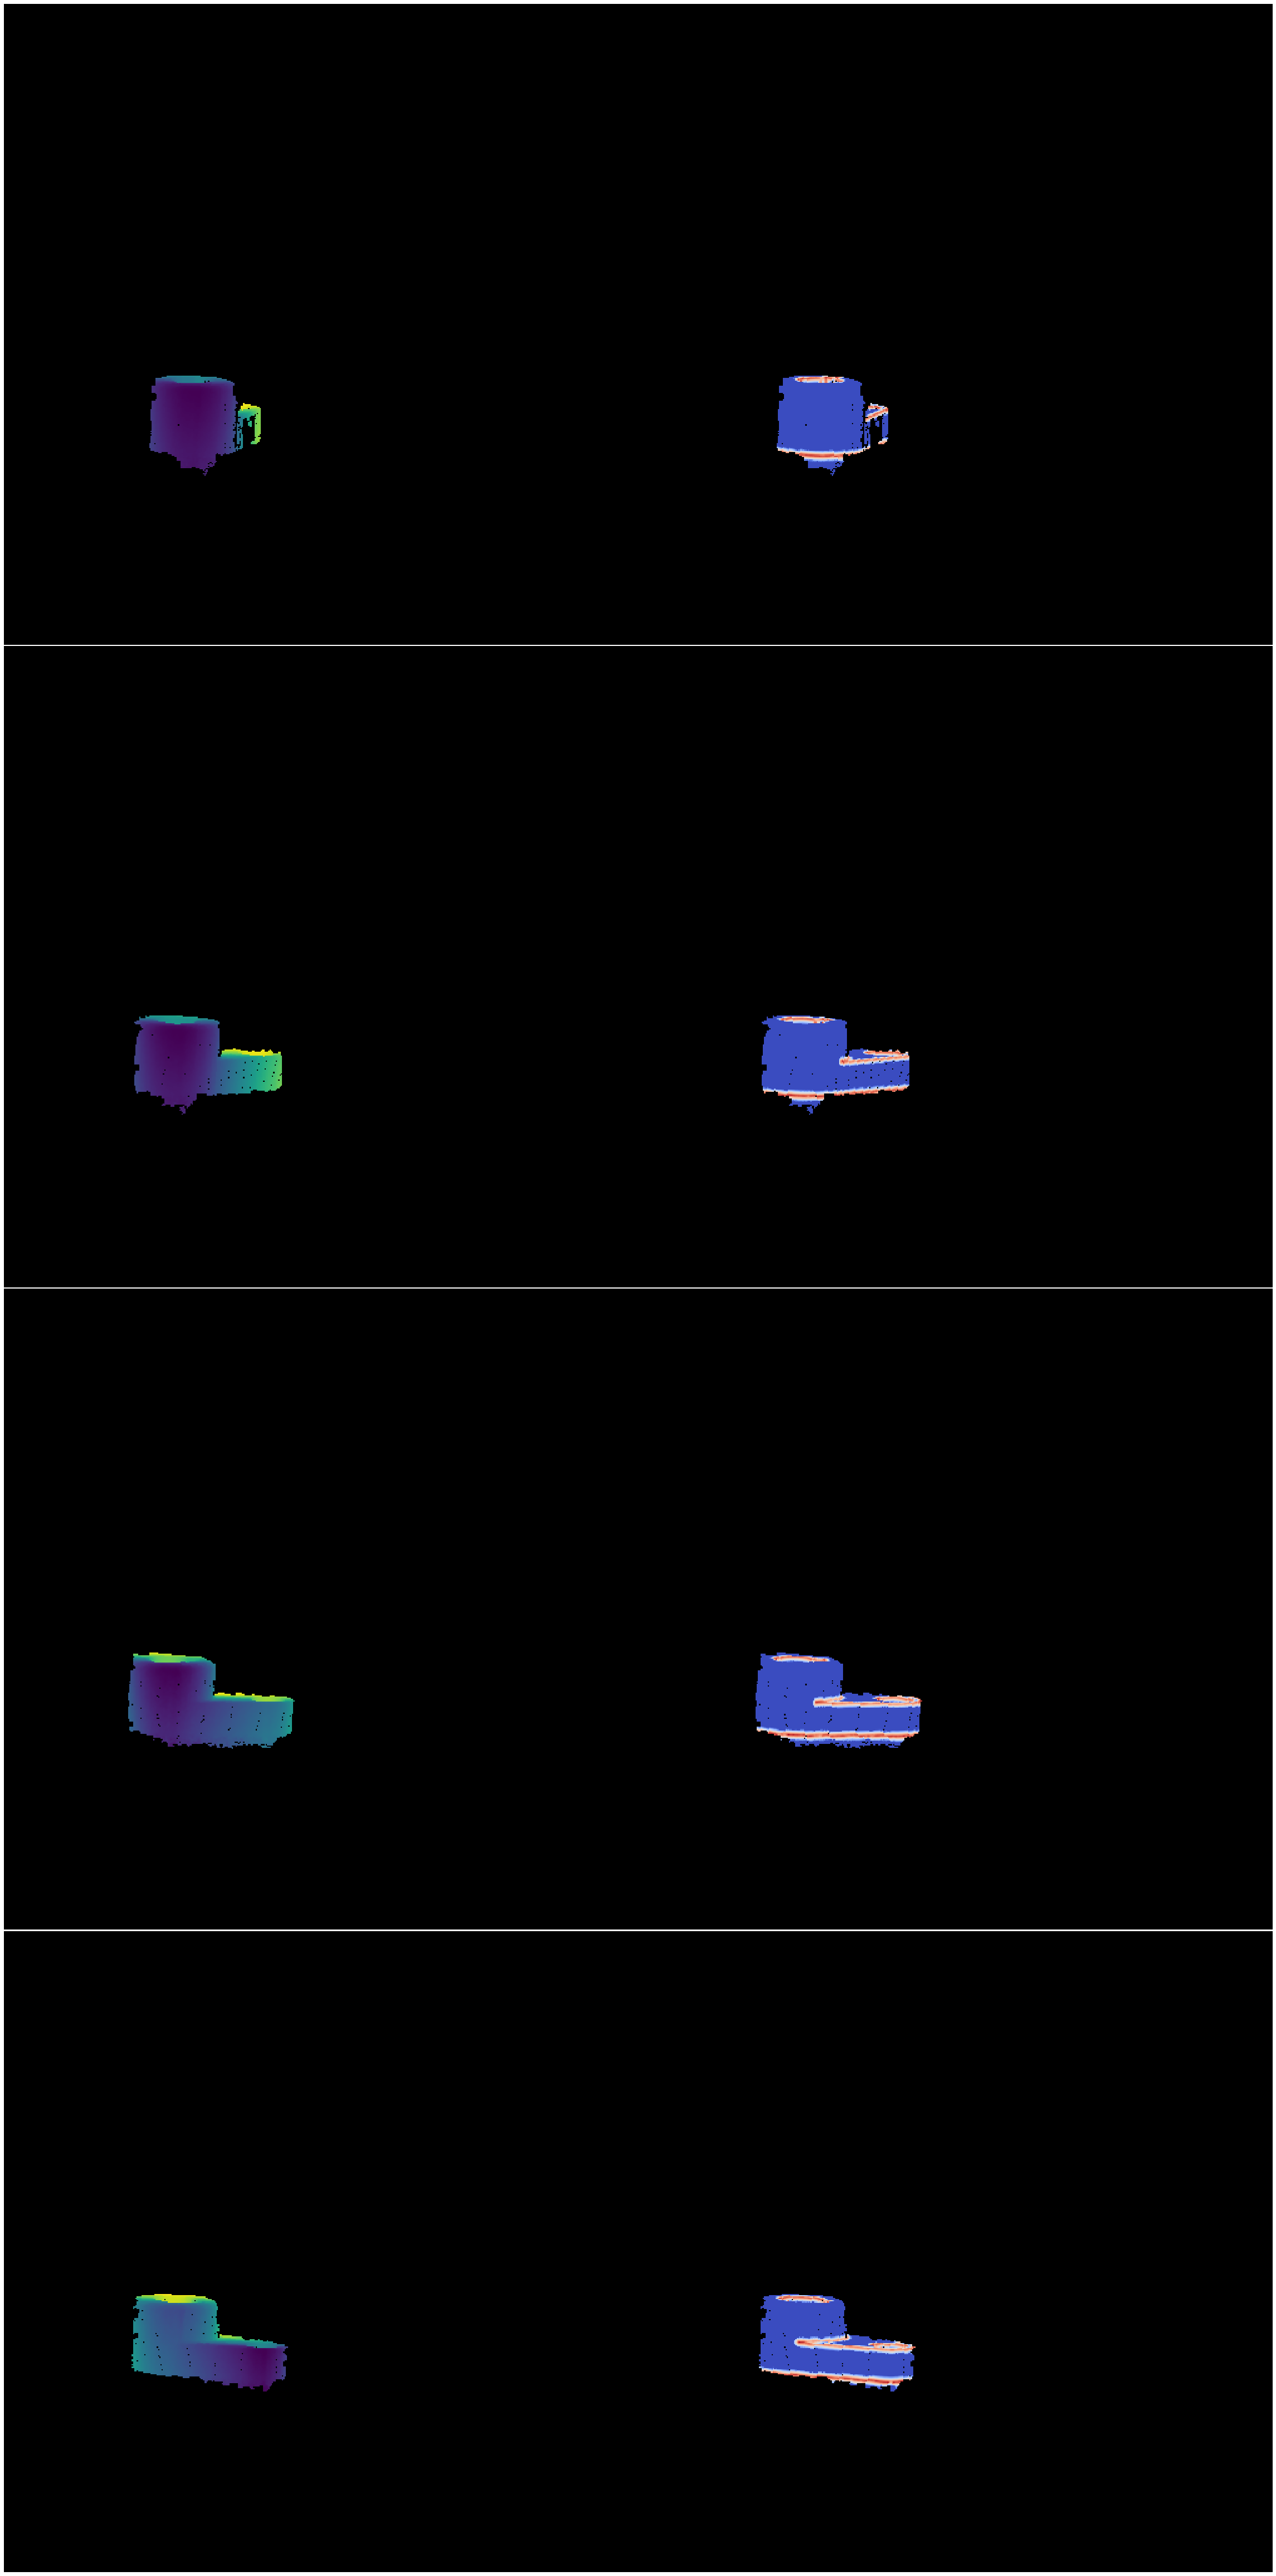

In [392]:
max_distance_to_feature = 2.5

name = '6top_folder_images'

gt_images_dataset = Hdf5File(
    '/logs/fusion_realworld_images/{}.hdf5'.format(name),
    io=AnnotatedViewIO,
    preload=PreloadTypes.LAZY,
    labels='*')

ImagePredictionsIO = io_struct.HDF5IO(
    {'distances': io_struct.Float64('distances')},
    len_label='distances',
    compression='lzf')

pred_images_dataset = Hdf5File(
    '/logs/fusion_realworld_images/{}/{}__predictions.hdf5'.format(name, name),
    io=ImagePredictionsIO,
    preload=PreloadTypes.LAZY,
    labels=['distances'])

gt_images = [p['points'] for p in gt_images_dataset]
gt_distances = [p['distances'] for p in gt_images_dataset]
pred_distances = [p['distances'] for p in pred_images_dataset]

for image, distances in zip(gt_images, pred_distances):
    image = image[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)]
    distances[image == 0] = 0
    distances[image != 0] = distances[image != 0] * max_distance_to_feature


s = 256
depth_images_for_display = [
    image[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)]
    for image in gt_images
]
# sharpness_images_for_display = gt_distances
sharpness_images_for_display = [
    distances[
        slice(1536 // 2 - s, 1536 // 2 + s),
        slice(2048 // 2 - s, 2048 // 2 + s)]
    for distances in gt_distances
]
display_depth_sharpness(
    depth_images=depth_images_for_display[:4],
    sharpness_images=sharpness_images_for_display[:4],
    ncols=1,
    axes_size=(16, 16),
    max_sharpness=max_distance_to_feature)

In [390]:
max_distance_to_feature

2.5

(array([4.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 6.000e+00, 1.700e+01,
        7.000e+00, 8.000e+00, 1.700e+01, 1.700e+01, 1.100e+01, 3.000e+00,
        1.000e+01, 1.000e+01, 8.000e+00, 1.100e+01, 1.200e+01, 1.100e+01,
        9.000e+00, 1.400e+01, 1.500e+01, 1.500e+01, 1.700e+01, 2.100e+01,
        2.600e+01, 2.100e+01, 2.400e+01, 2.700e+01, 2.100e+01, 2.300e+01,
        2.600e+01, 2.000e+01, 2.000e+01, 2.900e+01, 2.500e+01, 4.300e+01,
        3.800e+01, 3.000e+01, 4.100e+01, 4.400e+01, 3.600e+01, 3.700e+01,
        4.900e+01, 5.600e+01, 6.600e+01, 8.900e+01, 9.800e+01, 1.520e+02,
        2.370e+02, 2.749e+03]),
 array([0.64290738, 0.6500441 , 0.65718081, 0.66431753, 0.67145424,
        0.67859096, 0.68572767, 0.69286439, 0.70000111, 0.70713782,
        0.71427454, 0.72141125, 0.72854797, 0.73568468, 0.7428214 ,
        0.74995812, 0.75709483, 0.76423155, 0.77136826, 0.77850498,
        0.78564169, 0.79277841, 0.79991513, 0.80705184, 0.81418856,
        0.82132527, 0.82846199, 0.83

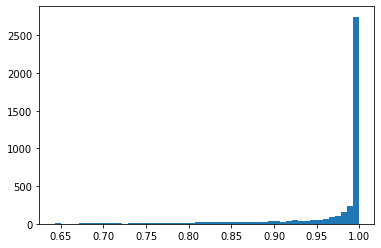

In [388]:
plt.hist(distances[distances!=0], bins=50)

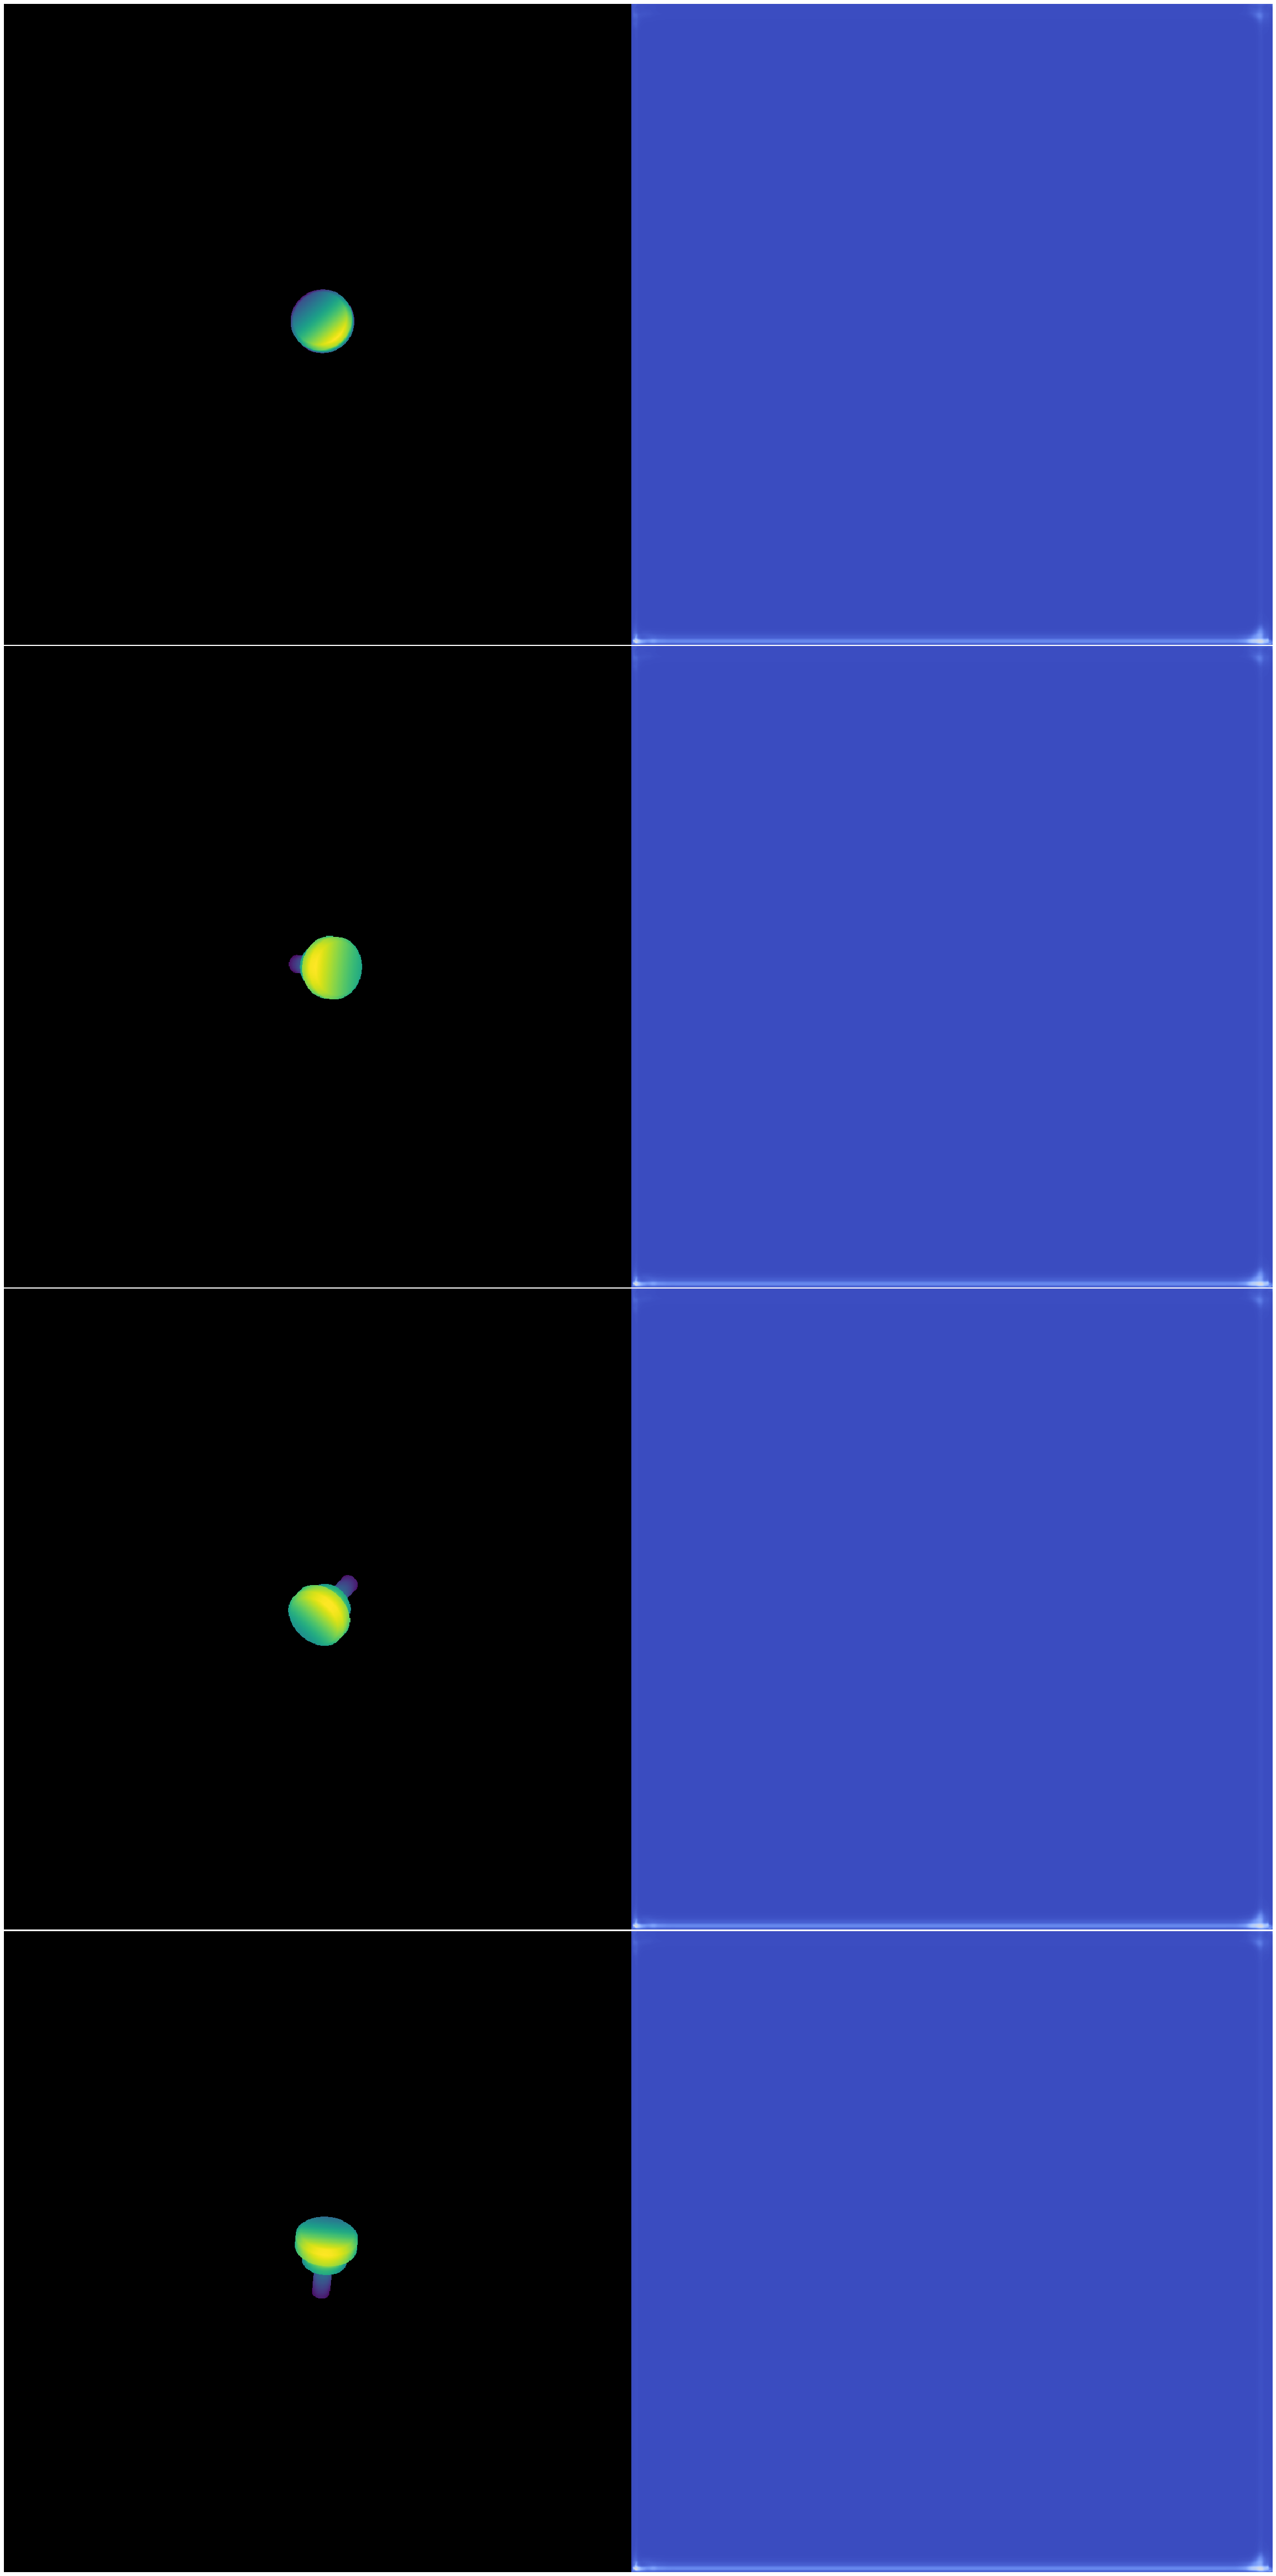

In [380]:
WholeDepthMapIO = io_struct.HDF5IO({
        'image': io_struct.Float64('image'),
        'normals': io_struct.Float64('normals'),
        'distances': io_struct.Float64('distances'),
        'directions': io_struct.Float64('directions'),
        'indexes_in_whole': io_struct.Float64('indexes_in_whole'),
        'item_id': io_struct.AsciiString('item_id'),
        'orig_vert_indices': io_struct.VarInt32('orig_vert_indices'),
        'orig_face_indexes': io_struct.VarInt32('orig_face_indexes'),
        'has_sharp': io_struct.Bool('has_sharp'),
        'num_sharp_curves': io_struct.Int8('num_sharp_curves'),
        'num_surfaces': io_struct.Int8('num_surfaces'),
        'camera_pose': io_struct.Float64('camera_pose'),
        'mesh_scale': io_struct.Float64('mesh_scale'),
        'has_smell_coarse_surfaces_by_num_faces': io_struct.Bool('has_smell_coarse_surfaces_by_num_faces'),
        'has_smell_coarse_surfaces_by_angles': io_struct.Bool('has_smell_coarse_surfaces_by_angles'),
        'has_smell_deviating_resolution': io_struct.Bool('has_smell_deviating_resolution'),
        'has_smell_sharpness_discontinuities': io_struct.Bool('has_smell_sharpness_discontinuities'),
        'has_smell_bad_face_sampling': io_struct.Bool('has_smell_bad_face_sampling'),
        'has_smell_mismatching_surface_annotation': io_struct.Bool('has_smell_mismatching_surface_annotation'),
        'has_smell_raycasting_background': io_struct.Bool('has_smell_raycasting_background'),
        'has_smell_depth_discontinuity': io_struct.Bool('has_smell_depth_discontinuity'),
        'has_smell_mesh_self_intersections': io_struct.Bool('has_smell_mesh_self_intersections'),
    },
    len_label='has_sharp',
    compression='lzf')

ImagePredictionsIO = io_struct.HDF5IO(
    {'distances': io_struct.Float64('distances')},
    len_label='distances',
    compression='lzf')

PointPatchPredictionsIO = io_struct.HDF5IO(
        {'points': io_struct.Float64('points'),
         'distances': io_struct.Float64('distances')},
        len_label='distances',
        compression='lzf')


name = 'abc_0051_00510077_3cb33817515aa6a5e8dd638d_000'

gt_fused_dataset = Hdf5File(
    '/logs/fusion_whole/{}__ground_truth.hdf5'.format(name),
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

pred_fused_dataset = Hdf5File(
    '/logs/fusion_whole/{}__min.hdf5'.format(name),
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')


gt_images_dataset = Hdf5File(
    '/logs/fusion_whole/{}.hdf5'.format(name),
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')

pred_images_dataset = Hdf5File(
    '/logs/fusion_whole/{}__predictions.hdf5'.format(name, name),
    io=ImagePredictionsIO,
    preload=PreloadTypes.LAZY,
    labels=['distances'])

gt_images = [p['image'] for p in gt_images_dataset]
gt_distances = [p['distances'] for p in gt_images_dataset]
pred_distances = [p['distances'] for p in pred_images_dataset]


depth_images_for_display = gt_images
sharpness_images_for_display = pred_distances

display_depth_sharpness(
    depth_images=depth_images_for_display[:4],
    sharpness_images=sharpness_images_for_display[:4],
    ncols=1,
    axes_size=(16, 16),
    max_sharpness=1.0)

In [378]:
pred_images_dataset[0]['distances'].max()

0.9992539882659912

In [337]:
# UnlabeledPointCloudIO = io.HDF5IO({
#         'points': io.Float64('points'),
#         'indexes_in_whole': io.Int32('indexes_in_whole'),
#         'distances': io.Float64('distances'),
#         'item_id': io.AsciiString('item_id'),
#     },
#     len_label='points',
#     compression='lzf')

# obj_filename = '/data/SharpF_200_01_21/3side_folder/00510848_589a11a3e0d0da0f7abae8a6_trimesh_003.obj'
# hdf5_filename = '/logs/40side_folder_images__adv60.hdf5'
# obj_mesh = get_mesh(hdf5_filename, obj_filename)


gt_dataset = Hdf5File(
    '/logs/40side_folder_images__ground_truth.hdf5',
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

pred_dataset = Hdf5File(
    '/logs/perspective_fusion/11side_images__adv60.hdf5',
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

# idx = np.random.choice(len(ground_truth_dataset))

# ground_truth = [patch for patch in ground_truth_dataset]
# points = ground_truth_dataset[idx]['points'].reshape((-1, 3))
# distances = ground_truth_dataset[idx]['distances']

# mesh = reindex_zerobased(
#     obj_mesh,
#     ground_truth_dataset[idx]['orig_vert_indices'],
#     ground_truth_dataset[idx]['orig_face_indexes'],
# )
# # distances = np.load('/logs/whole_models_inference_final/predictions/points/real_world_high/0.0/d6-v/regression/small_40/predictions/test_{}.npy'.format(idx))

# list_distances = [patch['distances'] for patch in ground_truth]
# list_indexes_in_whole = [patch['indexes_in_whole'].astype(int) for patch in ground_truth]
# list_points = [patch['points'].reshape((-1, 3)) for patch in ground_truth]
# n_points = np.concatenate([patch['indexes_in_whole'] for patch in ground_truth]).max() + 1

# fused_points_gt, fused_distances_gt, _ = fuse_points(
#     n_points, list_distances, list_indexes_in_whole, list_points)



display_sharpness2(
    None, plot_meshvert=False, meshvert_psize=0.01,
    samples=pred_dataset[0]['points'], 
    samples_distances=pred_dataset[0]['distances'],
    samples_color=0x0000ff, samples_psize=0.25,
    directions=None)


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [321]:
gt_dataset[0]['points']

array([[ -87.88287623,  -76.56716989,  -39.77723392],
       [ -87.5173267 ,  -76.93767579,  -39.69490037],
       [ -87.13764037,  -77.27815303,  -39.68098656],
       ...,
       [-117.15940923, -106.8125476 ,  -62.49006408],
       [-116.76661244, -107.07083002,  -62.69446169],
       [-116.40415605, -107.21532264,  -63.03033945]])

In [63]:
fused_distances_gt[fused_distances_gt<5]

array([1., 1., 1., ..., 1., 1., 1.])

In [21]:
def make_nice_visuals(
    ground_truth_filename,
    pred_filename,
    output_filename=None,
    display=False,
    display_res=DISPLAY_RES,
    invert=False,
    min_thr=1.0,
):
# item_id = '00500166_5894bbd701b2bb0fc88a6978_007'

# ground_truth_filename = os.path.join(
#     '/logs/whole_models_inference_final/combined/images/high_res/0.0/resnet152/regression/abc_0050_{}__ground_truth.hdf5'.format(item_id))
    ground_truth_dataset = Hdf5File(
        ground_truth_filename,
        io=PointPatchPredictionsIO,
        preload=PreloadTypes.LAZY,
        labels='*')

#     ground_truth = [patch for patch in ground_truth_dataset]
    points = ground_truth_dataset[0]['points']
    distances = ground_truth_dataset[0]['distances']
    print(len(points))
    if invert:
        distances = 1. - distances

    plot = display_sharpness(
        None, plot_meshvert=False, meshvert_psize=0.01,
        samples=points, 
        samples_distances=distances,
        samples_color=0x0000ff, samples_psize=display_res,
        directions=None,
        plot=None, display=False)


#     pred_filename = os.path.join(
#         '/logs/whole_models_inference_final/combined/images/high_res/0.0/resnet152/regression/abc_0050_{}__min.hdf5'.format(item_id))
    pred_dataset = Hdf5File(
        pred_filename,
        io=PointPatchPredictionsIO,
        preload=PreloadTypes.LAZY,
        labels='*')
    pred_points = pred_dataset[0]['points']
    pred_distances = pred_dataset[0]['distances']
    if invert:
        pred_distances = 1. - pred_distances
    
    pred_distances[pred_distances > min_thr] = min_thr
    pred_distances /= min_thr

    plot = display_sharpness(
        None, plot_meshvert=False, meshvert_psize=0.01,
        samples=pred_points, 
        samples_distances=pred_distances,
        samples_color=0x0000ff, samples_psize=display_res,
        directions=None,
        plot=plot, display=display)
    
    if None is not output_filename:
        with open(output_filename, 'w') as f:
            f.write(plot.get_snapshot())
    
    return plot

In [ ]:
item_id = 'nozel_decimated_17_nonoise.obj__13.2mm'
d = '/logs/whole_models_inference_final/combined/images/real_world_high/0.08/resnet152/regression'
ground_truth_filename = os.path.join(d, '{}__ground_truth.hdf5'.format(item_id))
pred_filename = os.path.join(d, '{}__min.hdf5'.format(item_id))

make_nice_visuals(
    ground_truth_filename,
    pred_filename,
    display=True,
    min_thr=0.2,
    output_filename='x.html')

2696516


In [ ]:
with open('/logs/whole_models_inference_final/printed_models.txt') as f:
    instance_names = f.read().splitlines()

In [ ]:
modality = 'images'
base_dir = os.path.join('/logs/whole_models_inference_final/combined', modality)
visuals_dir = '/logs/whole_models_inference_final/combined/visuals'
pred_variant = 'min'
noise_by_res = {
    'high_res': ['0.0', '0.005', '0.02', '0.08'],
    'med_res': ['0.0'],
    'low_res': ['0.0'],
}
RES_BY_NAME = {
    'high_res': HIGH_RES,
    'med_res': MED_RES,
    'low_res': LOW_RES,
}

for instance_name in instance_names:
    for res in ['high_res', 'med_res', 'low_res']:
        for noise in noise_by_res[res]:
#             for model in ['d6', 'd6-v']:
            for model in ['resnet152']:
                for task in ['regression', 'segmentation']:
                    print(modality, res, noise, model, task, instance_name)

                    ground_truth_filename = os.path.join(
                        base_dir, 
                        res,
                        noise,
                        model,
                        task,
                        'abc_0050_{}__ground_truth.hdf5'.format(instance_name))
                    pred_filename = os.path.join(
                        base_dir, 
                        res,
                        noise,
                        model,
                        task,
                        'abc_0050_{}__{}.hdf5'.format(instance_name, pred_variant))

                    if not os.path.exists(ground_truth_filename):
    #                     print('GT {} does not exist, skipping'.format(ground_truth_filename))
                        continue 

                    if not os.path.exists(pred_filename):
    #                     print('PRED {} does not exist, skipping'.format(pred_filename))
                        continue

                    output_filename = os.path.join(
                        visuals_dir,
                        '{modality}_{res}_{noise}_{model}_{task}_{file}'.format(
                            modality=modality,
                            res=res,
                            noise=noise,
                            model=model,
                            task=task,
                            file='abc_0050_{}__ground_truth__{}.html'.format(instance_name, pred_variant)
                        ))
                    if os.path.exists(output_filename):
    #                     print('OUTPUT {} exists, skipping'.format(output_filename))
                        continue

                    print(ground_truth_filename)
                    print(pred_filename)
                    print(output_filename)
                    print()

#                     make_nice_visuals(
#                         ground_truth_filename,
#                         pred_filename,
#                         display=False,
#                         output_filename=output_filename,
#                         display_res=RES_BY_NAME[res] * 1.5,
#                     )


In [ ]:
with open('/logs/whole_models_inference_final/ct_scans.txt') as f:
    instance_names = f.read().splitlines()
    
modality = 'images'
base_dir = os.path.join('/logs/whole_models_inference_final/combined', modality)
visuals_dir = '/logs/whole_models_inference_final/combined/visuals'
pred_variant = 'min'
noise_by_res = {
    'high_res': ['0.0', '0.005', '0.02', '0.08'],
    'med_res': ['0.0'],
    'low_res': ['0.0'],
}
RES_BY_NAME = {
    'high_res': HIGH_RES,
    'med_res': MED_RES,
    'low_res': LOW_RES,
}

for instance_name in instance_names:
    for res in ['high', 'med', 'low']:
        for noise in noise_by_res[res + '_res']:
#             for model in ['d6', 'd6-v']:
            for model in ['resnet152']:
                for task in ['regression', 'segmentation']:
                    print(modality, res, noise, model, task, instance_name)

                    ground_truth_filename = os.path.join(
                        base_dir, 
                        'real_world_' + res,
                        noise,
                        model,
                        task,
                        '{}__ground_truth.hdf5'.format(instance_name))
                    pred_filename = os.path.join(
                        base_dir, 
                        'real_world_' + res,
                        noise,
                        model,
                        task,
                        '{}__{}.hdf5'.format(instance_name, pred_variant))

                    if not os.path.exists(ground_truth_filename):
                        print('GT {} does not exist, skipping'.format(ground_truth_filename))
                        continue 

                    if not os.path.exists(pred_filename):
    #                     print('PRED {} does not exist, skipping'.format(pred_filename))
                        continue

                    output_filename = os.path.join(
                        visuals_dir,
                        '{modality}_{res}_{noise}_{model}_{task}_{file}'.format(
                            modality=modality,
                            res='real_world_' + res,
                            noise=noise,
                            model=model,
                            task=task,
                            file='{}__ground_truth__{}.html'.format(instance_name, pred_variant)
                        ))
                    if os.path.exists(output_filename):
    #                     print('OUTPUT {} exists, skipping'.format(output_filename))
                        continue

                    print(ground_truth_filename)
                    print(pred_filename)
                    print(output_filename)
                    print()

                    make_nice_visuals(
                        ground_truth_filename,
                        pred_filename,
                        display=False,
                        output_filename=output_filename,
                        display_res=RES_BY_NAME[res + '_res'] * 1.5,
                    )



In [ ]:
!ls /logs/whole_models_inference_final/combined/images/high_res/0.0/

In [ ]:
with open('/logs/whole_models_inference_final/sl_scans_points.txt') as f:
    instance_names = f.read().splitlines()

modality = 'points'
base_dir = os.path.join('/logs/whole_models_inference_final/combined', modality)
visuals_dir = '/logs/whole_models_inference_final/combined/visuals'
pred_variant = 'crop__adv60__min'
noise_by_res = {
    'high_res': ['0.0', '0.005', '0.02', '0.08'],
    'med_res': ['0.0'],
    'low_res': ['0.0'],
}
RES_BY_NAME = {
    'high_res': HIGH_RES,
    'med_res': MED_RES,
    'low_res': LOW_RES,
}

for instance_name in instance_names:
    for res in ['high', 'med', 'low']:
        for noise in noise_by_res[res + '_res']:
            for model in ['d6-v']:
#             for model in ['resnet152']:
                for task in ['regression']:
                    print(modality, res, noise, model, task, instance_name)

                    ground_truth_filename = os.path.join(
                        base_dir, 
                        'real_world_' + res,
                        noise,
                        model,
                        task,
                        '{}__ground_truth.hdf5'.format(instance_name))
                    pred_filename = os.path.join(
                        base_dir, 
                        'real_world_' + res,
                        noise,
                        model,
                        task,
                        '{}__{}.hdf5'.format(instance_name, pred_variant))

                    if not os.path.exists(ground_truth_filename):
                        print('GT {} does not exist, skipping'.format(ground_truth_filename))
                        continue 

                    if not os.path.exists(pred_filename):
    #                     print('PRED {} does not exist, skipping'.format(pred_filename))
                        continue

                    output_filename = os.path.join(
                        visuals_dir,
                        '{modality}_{res}_{noise}_{model}_{task}_{file}'.format(
                            modality=modality,
                            res='real_world_' + res,
                            noise=noise,
                            model=model,
                            task=task,
                            file='{}__ground_truth__{}.html'.format(instance_name, pred_variant)
                        ))
                    if os.path.exists(output_filename):
    #                     print('OUTPUT {} exists, skipping'.format(output_filename))
                        continue

                    print(ground_truth_filename)
                    print(pred_filename)
                    print(output_filename)
                    print()

#                     make_nice_visuals(
#                         ground_truth_filename,
#                         pred_filename,
#                         display=False,
#                         output_filename=output_filename,
#                         display_res=RES_BY_NAME[res + '_res'] * 1.5,
#                     )


In [ ]:
with open('/logs/whole_models_inference_final/printed_models.txt') as f:
    instance_names = f.read().splitlines()

modality = 'points'
base_dir = os.path.join('/logs/whole_models_inference_final/combined', modality)
visuals_dir = '/logs/whole_models_inference_final/combined/visuals'
pred_variant = 'vote_0.50'
noise_by_res = {
    'high_res': ['0.0', '0.005', '0.02', '0.08'],
    'med_res': ['0.0'],
    'low_res': ['0.0'],
}
RES_BY_NAME = {
    'high_res': HIGH_RES,
    'med_res': MED_RES,
    'low_res': LOW_RES,
}

for instance_name in instance_names:
    for res in ['high', 'med', 'low']:
        for noise in noise_by_res[res + '_res']:
            for model in ['voronoi', 'sharpness', 'ecnet']:
                    print(modality, res, noise, model, instance_name)

                    ground_truth_filename = os.path.join(
                        base_dir, 
                        res + '_res',
                        noise,
                        model,
                        'abc_0050_{}__ground_truth.hdf5'.format(instance_name))
                    pred_filename = os.path.join(
                        base_dir, 
                        res + '_res',
                        noise,
                        model,
                        'abc_0050_{}__{}.hdf5'.format(instance_name, pred_variant))

                    if not os.path.exists(ground_truth_filename):
                        print('GT {} does not exist, skipping'.format(ground_truth_filename))
                        continue 

                    if not os.path.exists(pred_filename):
                        print('PRED {} does not exist, skipping'.format(pred_filename))
                        continue

                    output_filename = os.path.join(
                        visuals_dir,
                        '{modality}_{res}_{noise}_{model}_{file}'.format(
                            modality=modality,
                            res=res + '_res',
                            noise=noise,
                            model=model,
                            file='{}__ground_truth__{}.html'.format(instance_name, pred_variant)
                        ))
                    if os.path.exists(output_filename):
    #                     print('OUTPUT {} exists, skipping'.format(output_filename))
                        continue

                    print(ground_truth_filename)
                    print(pred_filename)
                    print(output_filename)
                    print()

                    make_nice_visuals(
                        ground_truth_filename,
                        pred_filename,
                        display=False,
                        output_filename=output_filename,
                        display_res=RES_BY_NAME[res + '_res'] * 1.5,
                        invert=True
                    )



In [ ]:
ls /logs/whole_models_inference_final/combined/points/high/0.0/voronoi/

In [ ]:
with open('/logs/whole_models_inference_final/sl_scans_points.txt') as f:
    instance_names = f.read().splitlines()

modality = 'points'
base_dir = os.path.join('/logs/whole_models_inference_final/combined', modality)
visuals_dir = '/logs/whole_models_inference_final/combined/visuals'
pred_variant = 'vote_0.50'

for instance_name in instance_names:
    for model in ['voronoi']:
        print(modality, model, instance_name)

        ground_truth_filename = os.path.join(
            base_dir, 
            'real_world',
            model,
            '{}__ground_truth.hdf5'.format(instance_name))
        pred_filename = os.path.join(
            base_dir,
            'real_world',
            model,
            '{}__{}.hdf5'.format(instance_name, pred_variant))

        if not os.path.exists(ground_truth_filename):
            print('GT {} does not exist, skipping'.format(ground_truth_filename))
            continue 

        if not os.path.exists(pred_filename):
#                     print('PRED {} does not exist, skipping'.format(pred_filename))
            continue

        output_filename = os.path.join(
            visuals_dir,
            '{modality}_{model}_{file}'.format(
                modality=modality,
                res='real_world',
                model=model,
                file='{}__ground_truth__{}.html'.format(instance_name, pred_variant)
            ))
        if os.path.exists(output_filename):
#                     print('OUTPUT {} exists, skipping'.format(output_filename))
            continue

        print(ground_truth_filename)
        print(pred_filename)
        print(output_filename)
        print()

        make_nice_visuals(
            ground_truth_filename,
            pred_filename,
            display=False,
            output_filename=output_filename,
            display_res=RES_BY_NAME[res + '_res'] * 1.5,
            invert=True
        )



In [ ]:
ground_truth_dataset = Hdf5File(
    '/logs/whole_models_inference_final/combined/points/real_world/voronoi/bat_320__ground_truth.hdf5',
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

points = ground_truth_dataset[0]['points']
distances = ground_truth_dataset[0]['distances']
print(len(points))

display_sharpness2(
    None, plot_meshvert=False, meshvert_psize=0.01,
    samples=points, 
    samples_distances=distances,
    samples_color=0x0000ff, samples_psize=0.01,
    directions=None)

In [31]:
UnlabeledSLDepthMapIO = io.HDF5IO({
        'image': io.Float64('image'),
        'image_offset': io.Float64('image_offset'),
        'item_id': io.AsciiString('item_id'),
        'camera_extrinsics': io.Float64('camera_extrinsics'),
        'camera_intrinsics_f': io.Float64('camera_intrinsics_f'),
        'camera_intrinsics_s': io.Float64('camera_intrinsics_s'),
    },
    len_label='has_sharp',
    compression='lzf')

In [86]:
gt_images_dataset = Hdf5File(
    '/data/abc/sharp_features_whole_models/whole_images/low_complexity/abc_0022_00221312_0cdd179f2b755db6d27ea303_001.hdf5',
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels='*')

pred_images_dataset = Hdf5File(
    '/logs/whole_images/nobg_nodisc/abc_0022_00221312_0cdd179f2b755db6d27ea303_001__predictions.hdf5',
    io=WholeDepthMapIO,
    preload=PreloadTypes.LAZY,
    labels=['distances'])

gt_images = [p['image'][128:-128, 128:-128] for p in gt_images_dataset]
gt_distances = [p['distances'][128:-128, 128:-128] for p in gt_images_dataset]
pred_images_distances = [p['distances'][128:-128, 128:-128] for p in pred_images_dataset]

File /logs/whole_images/nobg_nodisc/abc_0022_00221312_0cdd179f2b755db6d27ea303_001__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>
File /logs/whole_images/nobg_nodisc/abc_0022_00221312_0cdd179f2b755db6d27ea303_001__predictions.hdf5 is not compatible with Hdf5File I/O interface <class 'sharpf.utils.abc_utils.hdf5.io_struct.HDF5IO'>


In [87]:
pred_images_distances_masked = []
for image, distances in zip(gt_images, pred_images_distances):
    distances_masked = np.zeros_like(distances)
    distances_masked[image == 0.] = 0.
    distances_masked[image != 0.] = distances[image != 0.]
    pred_images_distances_masked.append(distances_masked)

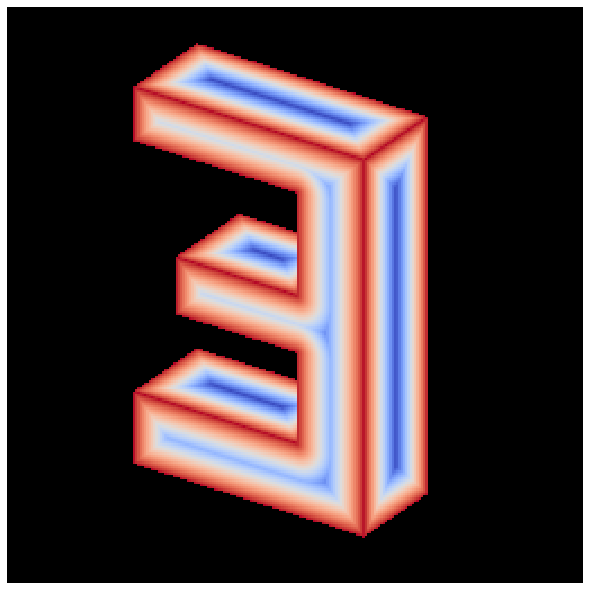

In [91]:


display_depth_sharpness(
#     depth_images=[gt_images[4].T],
    sharpness_images=[gt_distances[4].T],
    axes_size=(8, 8),
    ncols=1
)

In [ ]:
plt.hist(gt_images[0].ravel()[gt_images[0].ravel()!=0] - min(gt_images[0].ravel()[gt_images[0].ravel()!=0]), bins=100)

In [95]:
import trimesh.transformations as tt

array([[ 0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [-0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [168]:
# pred_filename = os.path.join('/logs/whole_models_inference/abc_0022_00220226_b79b40ef8721383269a6542c_000__crop__linreg.hdf5')
# pred_filename = os.path.join(
#     '/logs/whole_images/arbitrary/abc_0022_00221312_0cdd179f2b755db6d27ea303_001__min.hdf5')
input_dir = '/logs/whole_models_inference_final/combined/points/low_res/0.0/d6/regression'
pred_dataset = Hdf5File(
    os.path.join(input_dir, 'abc_0050_00507625_b39680dc8dc650ec01956bbe_011__crop__linreg.hdf5'),
    io=PointPatchPredictionsIO,
    preload=PreloadTypes.LAZY,
    labels='*')

pred_points = pred_dataset[0]['points'] - np.mean(pred_dataset[0]['points'], axis=0)
pred_distances = pred_dataset[0]['distances']

display_sharpness(None, plot_meshvert=False, meshvert_psize=0.01,
                  samples=tt.transform_points(pred_points, tt.euler_matrix(-np.pi/4, 0, 0, axes='sxyz'))*0.15, 
                  samples_distances=pred_distances,
                  samples_color=0x0000ff, samples_psize=LOW_RES * 2.5 *0.15,
                  directions=None)

Output()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0, 0…